In [5]:
import zarr
import xarray as xr
import matplotlib.pyplot as plt
import gzip
import pickle
import numpy as np

In [2]:
p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*10000

print(p_std[34])

29000.000000000007


In [14]:
# %matplotlib notebook
from scipy import interpolate
from sympl import get_constant

import os
os.chdir('/home/scratch/Abel_data/long_run2')  


Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*10000
# print(len(p_std))
# print(p_std)

def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out

lat1=12
lat2=16
lon1=36
lon2=40

common=xr.open_zarr("common",consolidated=False)
lat_rad=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_rad=np.radians(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

print(lat_deg)

lat_diff=lat_deg[0,0]-lat_deg[1,0]
lon_diff=lon_deg[0,1]-lon_deg[0,0]

Lx=np.radians(lon_diff)*6371*1000
Ly=np.radians(lat_diff)*6371*1000

def calc_dse(air_temp, air_press):
    
    dp=(air_press[:-1]-air_press[1:])
    
    dz=Rd*air_temp/g*np.log(air_press[:-1,np.newaxis,np.newaxis]/air_press[1:,np.newaxis,np.newaxis])
    z=dz.cumsum(axis=0)
#     print(z.mean(axis=(1,2)))
    
    dse=((Cp*air_temp+g*z)*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad)*Lx*Ly).sum(axis=(1,2))
    
    return dse

dse_arr=[]
DSE_arr=[]
DSE_start=[]

with gzip.open('/home/scratch/Abel_data/heat_indexv4_cut', 'rb') as f:
    heat_index= pickle.load(f)

test=0

for e in heat_index:
    
#     if test==100:
#         break
    
    test=test+1
    print(test)
    
    i=e[0]
    j=int(e[1])
    t_list=e[2]
    ignore=0

    for t in t_list:
        
        # .mean(dim='time')
        D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
        temp=D['air_temperature'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        uwind=D['eastward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        nwind=D['northward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        press=D['air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        spress=D['surface_air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        sens=D['surface_upward_sensible_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        latent=D['surface_upward_latent_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        bound=D['boundary_layer_height'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
#         print(bound.mean().values)

        press_test=D['air_pressure'][t].sel(lat=range(lat1-1,lat2+1),lon=range(lon1-1,lon2+1))
        if np.min(press_test.values[0])<97000:
            print(np.min(press_test.values[0]))
            print('ERROR')
            ignore=1
            continue

        uwind=interpol1d(uwind, press)
        nwind=interpol1d(nwind, press)
        temp=interpol1d(temp, press)
        press_int=np.insert(p_std, 0, 101300)

        DSE=calc_dse(temp[:], press_int[:])
        dse_arr.append(DSE)
    
    if ignore==0:
        dse_arr=np.array(dse_arr)
        DSE_arr.append(dse_arr[:])
        DSE_start.append(dse_arr[0])
#     DSE_arr.append(dse_arr[1:]-dse_arr[:-1])
#     else:
#         print('removed')
#         DSE_arr.append(np.array([]))
#         DSE_start.append(np.array([]))
    dse_arr=[]

# DSE_arr=np.array(DSE_arr)

with gzip.open('/home/scratch/Abel_data/Conv_prioriv4', 'wb') as f:
    pickle.dump(DSE_arr, f)

with gzip.open('/home/scratch/Abel_data/Conv_startv4', 'wb') as f:
    pickle.dump(DSE_start, f)

[[54.41619953 54.41619953 54.41619953 54.41619953]
 [51.62573367 51.62573367 51.62573367 51.62573367]
 [48.83524097 48.83524097 48.83524097 48.83524097]
 [46.04472663 46.04472663 46.04472663 46.04472663]]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226

In [13]:
# %matplotlib notebook
from sympl import get_constant
from scipy import interpolate
import copy

Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

import os
os.chdir('/home/scratch/Abel_data/long_run2')  

Lv=2260000

lat1=11
lat2=17
lon1=35
lon2=41

common=xr.open_zarr("common",consolidated=False)
lat_rad=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_rad=np.radians(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_diff=lat_deg[0,0]-lat_deg[1,0]
lon_diff=lon_deg[0,1]-lon_deg[0,0]

Lx=np.radians(lon_diff)*6371*1000
Ly=np.radians(lat_diff)*6371*1000

clim=xr.open_zarr("/home/scratch/Abel_data/climatology_1000",consolidated=False)
temp_clim=clim['air_temperature'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
uwind_clim=clim['eastward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
nwind_clim=clim['northward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
press_clim=clim['air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
spress_clim=clim['surface_air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
sens_clim=clim['surface_upward_sensible_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
latent_clim=clim['surface_upward_latent_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*10000

def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out


convergenceh=[]
convergencev=[]
CONVh=[]
CONVv=[]

with gzip.open('/home/scratch/Abel_data/heat_indexv4', 'rb') as f:
    heat_index= pickle.load(f)

heat_index_copy=copy.deepcopy(heat_index)
# print(heat_index_copy)

test=0

for e in heat_index:
    
#     if test==35:
#         break
        
    test=test+1
    
    print(test)

    i=e[0]
    j=int(e[1])
#     print(i,j)
    t_list=e[2]
    ignore=0

    for t in t_list:
        
#         t=t_0+k
        D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
        temp=D['air_temperature'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        uwind=D['eastward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        nwind=D['northward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        press=D['air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        spress=D['surface_air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        sens=D['surface_upward_sensible_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        latent=D['surface_upward_latent_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

        if np.min(press.values[0])<97000:
            if ignore==0:
                ignore=1
                heat_index_copy.remove(e)
            print(np.min(press.values[0]))
            print('ERROR')
            continue

        uwind=interpol1d(uwind, press)
        nwind=interpol1d(nwind, press)
        temp=interpol1d(temp, press)

        rho=(p_std[:,np.newaxis,np.newaxis]/(Rd*temp))[:,1:-1,1:-1]

        press_int=np.insert(p_std, 0, 101300)       

        # dz calculation

        dp=(press_int[:-1]-press_int[1:])

        dz=Rd*temp/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
        z=dz.cumsum(axis=0)

        dse=Cp*temp+g*z

        dudx=(uwind[:,1:-1,2:]-uwind[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
        dvdy=(nwind[:,2:,1:-1]*np.cos(lat_rad[2:,1:-1])-nwind[:,:-2,1:-1]*np.cos(lat_rad[:-2,1:-1]))/((lat_rad[2:,1:-1]-lat_rad[:-2,1:-1])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))

        dwdp=-(dudx+dvdy)
        w=np.cumsum(dwdp*-dp[:,np.newaxis,np.newaxis],axis=0)

#         dDdx=(dse[:,1:-1,2:]*uwind[:,1:-1,2:]-dse[:,1:-1,:-2]*uwind[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
#         dDdy=(dse[:,2:,1:-1]*nwind[:,2:,1:-1]*np.cos(lat_rad[2:,1:-1])-dse[:,:-2,1:-1]*nwind[:,:-2,1:-1]*np.cos(lat_rad[:-2,1:-1]))/((lat_rad[2:,1:-1]-lat_rad[:-2,1:-1])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
        
        dDdx=uwind[:,1:-1,1:-1]*(dse[:,1:-1,2:]-dse[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
        dDdy=nwind[:,1:-1,1:-1]*(dse[:,2:,1:-1]-dse[:,:-2,1:-1])/((lat_rad[2:,1:-1]-lat_rad[:-2,1:-1])*6371*1000)

        
        dDdp=dDdx.copy()
#         dDdp[1:]=(dse[1:,1:-1,1:-1]*w[1:,:,:]-dse[:-1,1:-1,1:-1]*w[:-1,:,:])/(dp[1:,np.newaxis,np.newaxis])
        dDdp[1:]=w[1:,:,:]*(dse[1:,1:-1,1:-1]-dse[:-1,1:-1,1:-1])/(-dp[1:,np.newaxis,np.newaxis])
        dDdp[0]=w[0]*(dse[1,1:-1,1:-1]-dse[0,1:-1,1:-1])/(-dp[1])
#         dDdp[0]=dse[0,1:-1,1:-1]*w[0]/(dp[0]) # This one is wrong

#         conv_flux=-(dDdx+dDdy+dDdp)
#         conv=((conv_flux*dp[:,np.newaxis,np.newaxis])/g*np.cos(lat_rad[1:-1,1:-1])*Lx*Ly)[:].sum(axis=(1,2))*86400
        
        conv_flux=-(dDdx+dDdy)
        convh=((conv_flux*dp[:,np.newaxis,np.newaxis])/g*np.cos(lat_rad[1:-1,1:-1])*Lx*Ly)[:].sum(axis=(1,2))*86400
        
        conv_flux=-(dDdp)
        convv=((conv_flux*dp[:,np.newaxis,np.newaxis])/g*np.cos(lat_rad[1:-1,1:-1])*Lx*Ly)[:].sum(axis=(1,2))*86400

        convergenceh.append(convh)
        convergencev.append(convv)
    
    if ignore==0:
        convergenceh=np.array(convergenceh)
        convergencev=np.array(convergencev)
        CONVh.append((convergenceh[1:]+convergenceh[:-1])/2)
        CONVv.append((convergencev[1:]+convergencev[:-1])/2)
#     else:
#         CONVh.append(np.array([]))
#         CONVv.append(np.array([]))
    convergenceh=[]
    convergencev=[]

print(len(heat_index), len(heat_index_copy))
with gzip.open('/home/scratch/Abel_data/Conv_datv4', 'wb') as f:
    pickle.dump([CONVh,CONVv], f)

with gzip.open('/home/scratch/Abel_data/heat_indexv4_cut', 'wb') as f:
    pickle.dump(heat_index_copy, f)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
96735.05
ERROR
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
96863.91
ERROR
96038.38
ERROR
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
96967.39
ERROR
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
96714.06
ERROR
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
2

1347


/tmp/ipykernel_744971/3005901810.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  conv=np.array(convh)+np.array(convv)


0.9315417925964582 0.08201106733929878


<IPython.core.display.Javascript object>


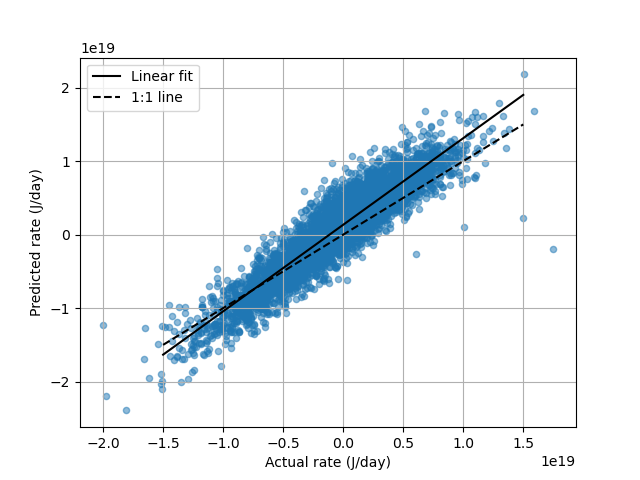

0.919797043238133
1.3264875580897482e+18
LinregressResult(slope=1.178459670378994, intercept=1.3436867915744404e+18, rvalue=0.9197970432381333, pvalue=0.0, stderr=0.005861715067596709, intercept_stderr=2.308053444342954e+16)
0.818004068531697 0.8460266007496124
-5.264549257400952e+17
6.719495669972129e+18
-7.245950595712224e+18
4.14946937993459e+18


In [33]:
%matplotlib notebook
import seaborn as sns
import scipy.stats
from scipy import interpolate

with gzip.open('/home/scratch/Abel_data/heat_indexv4_cut', 'rb') as f:
    heat_index= pickle.load(f)
    
with gzip.open('/home/scratch/Abel_data/Conv_datv4', 'rb') as f:
    convh,convv=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/Conv_prioriv4', 'rb') as f:
    prio=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/Conv_startv4', 'rb') as f:
    st=pickle.load(f)
    
res=[]
dse_res=[]
check=[]
res_diff=[]
int_check=[]

xx=[]
yy=[]
corr=[]
j=7
print(len(convh))
for i in range(len(convh)):

    # p_std = np.arange(0.5, 9.6 ,0.5)[::-1]*10000
    p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*100
#     print(p_std[7])

    # plt.plot(prio[i][:,:j].sum(axis=1))

#     conv=convh+convv
    # plt.plot(st[i][:j].sum()+np.insert(conv[i][:,:j].sum(axis=1),0,0).cumsum())
    
    first=prio[i][1:,:j].sum(axis=1)-prio[i][:-1,:j].sum(axis=1)
    int_check.append(np.mean(np.cumsum(first)))
    dse_res.append(np.sum(first))
#     plt.plot(first, label='Actual')
    xx=xx+first.tolist()

#     conv=np.array(convh)
    conv=np.array(convh)+np.array(convv)
    second=conv[i][:,:j].sum(axis=1)
    check.append(np.sum(second))
    yy=yy+second.tolist()
#     plt.plot(second, label='Calculated from advection')
    corr.append(scipy.stats.pearsonr(first,second)[0])
    
    res.append((first-second))
    res_diff.append(np.sum(first-second))
    
#     plt.legend()
#     plt.xlabel('Time (days)')
#     plt.ylabel('DSE difference (J)')
#     plt.show()

print(np.mean(corr), np.std(corr))
# plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('DSE difference (J)')

print(scipy.stats.pearsonr(xx,yy)[0])
plt.scatter(xx,yy,s=20,alpha=0.5)
print(np.mean(np.array(yy)-np.array(xx)))
plt.grid()
print(scipy.stats.linregress(xx,yy))
m=scipy.stats.linregress(xx,yy)[0]
x=scipy.stats.linregress(xx,yy)[1]

from sklearn.metrics import r2_score 
R_square = r2_score(np.array(xx)*m+x, yy)
print(R_square, scipy.stats.linregress(xx,yy)[2]**2)

xarr=np.linspace(-1.5e19,1.5e19,100)
yarr=xarr*m+x
plt.plot(xarr,yarr,color='black', label='Linear fit')
plt.plot(xarr,xarr,color='black', label='1:1 line', linestyle='dashed')
plt.legend()
plt.xlabel('Actual rate (J/day)')
plt.ylabel('Predicted rate (J/day)')
# plt.title('DSE convergence comparison')
# print(np.mean(np.array(yy)-np.array(xx)))
# print(np.mean(yy))
# plt.savefig('/home/data/lab_abel/Paper1/DSE_forcing.pdf', bbox_inches='tight',dpi=900)
# print(res)

print(np.mean(dse_res))
print(np.mean(check))
print(np.mean(res_diff))
print(np.mean(int_check))

with gzip.open('/home/scratch/Abel_data/heat_residuev4', 'wb') as f:
    pickle.dump(res, f)

In [15]:
# %matplotlib notebook
from scipy import interpolate
from sympl import get_constant

import os
os.chdir('/home/scratch/Abel_data/long_run2')  


Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*10000
# print(len(p_std))
# print(p_std)

def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out

lat1=12
lat2=16
lon1=36
lon2=40

common=xr.open_zarr("common",consolidated=False)
lat_rad=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_rad=np.radians(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_diff=lat_deg[0,0]-lat_deg[1,0]
lon_diff=lon_deg[0,1]-lon_deg[0,0]

Lx=np.radians(lon_diff)*6371*1000
Ly=np.radians(lat_diff)*6371*1000

stemp_arr=[]
STEMP_arr=[]

with gzip.open('/home/scratch/Abel_data/heat_indexv4_cut', 'rb') as f:
    heat_index= pickle.load(f)

test=0

for e in heat_index:
    
#     if test==100:
#         break
    
    test=test+1
    print(test)
    
    i=e[0]
    j=int(e[1])
    t_list=e[2]
    ignore=0

    for t in t_list:
        
        # .mean(dim='time')
        D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
        temp=D['air_temperature'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
#         print(bound.mean().values)

        press_test=D['air_pressure'][t].sel(lat=range(lat1-1,lat2+1),lon=range(lon1-1,lon2+1))
        if np.min(press_test.values[0])<97000:
            print(np.min(press_test.values[0]))
#             ignore=1
            continue

        stemp=temp[0].mean()
        stemp_arr.append(stemp)
    

    stemp_arr=np.array(stemp_arr)
    STEMP_arr.append(stemp_arr)
    stemp_arr=[]

# DSE_arr=np.array(DSE_arr)

with gzip.open('/home/scratch/Abel_data/stempv4', 'wb') as f:
    pickle.dump(STEMP_arr, f)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


0.9698016222653025 0.054102632209991536
0.9622364724063865


<IPython.core.display.Javascript object>


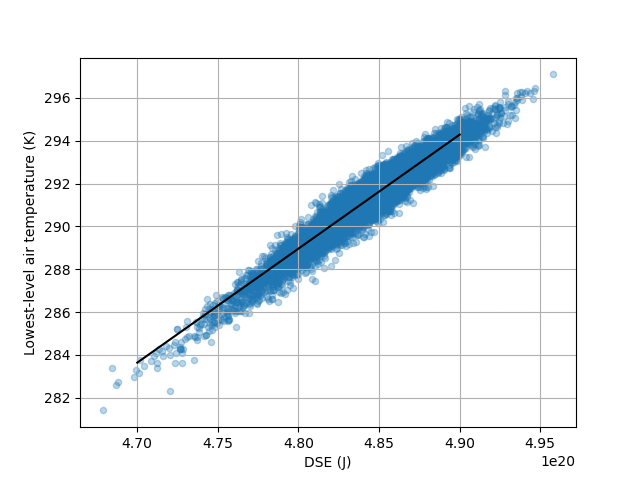

m: 5.324161022769655e-19
x: 33.40670414539068


Text(0, 0.5, 'Lowest-level air temperature (K)')

In [6]:
%matplotlib notebook
import seaborn as sns
import scipy.stats
from scipy import interpolate

with gzip.open('/home/scratch/Abel_data/heat_indexv4_cut', 'rb') as f:
    heat_index= pickle.load(f)

with gzip.open('/home/scratch/Abel_data/Conv_prioriv4', 'rb') as f:
    prio=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/stempv4', 'rb') as f:
    stemp=pickle.load(f)

xx=[]
yy=[]
corr=[]
j=7
for i in range(len(heat_index)):

    # p_std = np.arange(0.5, 9.6 ,0.5)[::-1]*10000
    p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*100
#     print(p_std[7])

    # plt.plot(prio[i][:,:j].sum(axis=1))

#     conv=convh+convv
    # plt.plot(st[i][:j].sum()+np.insert(conv[i][:,:j].sum(axis=1),0,0).cumsum())
    
    first=prio[i][:,:j].sum(axis=1)
    xx=xx+first.tolist()
#     plt.plot(first, label='Actual')

    second=stemp[i]
    yy=yy+second.tolist()
#     plt.plot(second, label='Calculated from advection')
    corr.append(scipy.stats.pearsonr(first,second)[0])
#     plt.legend()
#     plt.xlabel('Time (days)')
#     plt.ylabel('DSE difference (J)')
#     plt.show()

print(np.mean(corr), np.std(corr))

print(scipy.stats.pearsonr(xx,yy)[0])
plt.scatter(xx,yy,s=20,alpha=0.3)
plt.grid()
m=scipy.stats.linregress(xx,yy)[0]
print('m:', m)
x=scipy.stats.linregress(xx,yy)[1]
print('x:', x)
xarr=np.linspace(4.7e20,4.9e20,100)
yarr=xarr*m+x
plt.plot(xarr,yarr,color='black', label='Linear fit')
# plt.legend()
plt.xlabel('DSE (J)')
plt.ylabel('Lowest-level air temperature (K)')
# plt.title('DSE vs air temperature')
# plt.savefig('/home/data/lab_abel/Paper1/DSE_temp.pdf', bbox_inches='tight',dpi=900)

In [2]:
############################################# xtra code #######################################

%matplotlib notebook
from sympl import get_constant
from scipy import interpolate

import os
os.chdir('/home/scratch/Abel_data/long_run2')  

Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

Lv=2260000

lat1=13
lat2=19
lon1=35
lon2=41

common=xr.open_zarr("common",consolidated=False)
lat_rad=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_rad=np.radians(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_diff=lat_deg[0,0]-lat_deg[1,0]
lon_diff=lon_deg[0,1]-lon_deg[0,0]

Lx=np.radians(lon_diff)*6371*1000
Ly=np.radians(lat_diff)*6371*1000

clim=xr.open_zarr("/home/scratch/Abel_data/climatology_500",consolidated=False)
temp_clim=clim['air_temperature'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
uwind_clim=clim['eastward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
nwind_clim=clim['northward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
press_clim=clim['air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
spress_clim=clim['surface_air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
sens_clim=clim['surface_upward_sensible_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
latent_clim=clim['surface_upward_latent_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*10000

def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out


convergenceh=[]
convergencev=[]
CONVh=[]
CONVv=[]
vert=[]

with gzip.open('/home/scratch/Abel_data/heat_indexk', 'rb') as f:
    heat_index= pickle.load(f)

test=0

for e in heat_index:
    
#     if test==20:
#         break
        
    test=test+1
    
    print(test)

    i=e[0]
    j=int(e[1])
#     print(i,j)
    t_list=e[2]
    ignore=0
    
    first=0
    for t in t_list:
        
#         t=t_0+k
        D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
        temp=D['air_temperature'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        uwind=D['eastward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        nwind=D['northward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        press=D['air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        spress=D['surface_air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        sens=D['surface_upward_sensible_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        latent=D['surface_upward_latent_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

        if np.min(press.values[0])<97000:
#             ignore=1
            print(np.min(press.values[0]))
            continue

        uwind=interpol1d(uwind, press)
        nwind=interpol1d(nwind, press)
#         temp=interpol1d(temp, press)

#         rho=(p_std[:,np.newaxis,np.newaxis]/(Rd*temp))[:,1:-1,1:-1]

        press_int=np.insert(p_std, 0, 101300)       

        # dz calculation

        dp=(press_int[:-1]-press_int[1:])

#         dz=Rd*temp/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
#         z=dz.cumsum(axis=0)

#         dse=Cp*temp+g*z

        dudx=(uwind[:,1:-1,2:]-uwind[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
        dvdy=(nwind[:,2:,1:-1]*np.cos(lat_rad[2:,1:-1])-nwind[:,:-2,1:-1]*np.cos(lat_rad[:-2,1:-1]))/((lat_rad[2:,1:-1]-lat_rad[:-2,1:-1])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))

        dwdp=-(dudx+dvdy)
        w=np.cumsum(dwdp*-dp[:,np.newaxis,np.newaxis],axis=0)
        
        if first==0:
            vert.append(w.mean(axis=(1,2)))
        first=first+1
        
# plt.gca().invert_yaxis()

with gzip.open('/home/scratch/Abel_data/vertk', 'wb') as f:
    pickle.dump(vert, f)

/home/data/miniconda3/lib/python3.8/site-packages/sympl/_core/dataarray.py:6: FutureWarning: xarray subclass DataArray should explicitly define __slots__
  class DataArray(xr.DataArray):


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


<IPython.core.display.Javascript object>


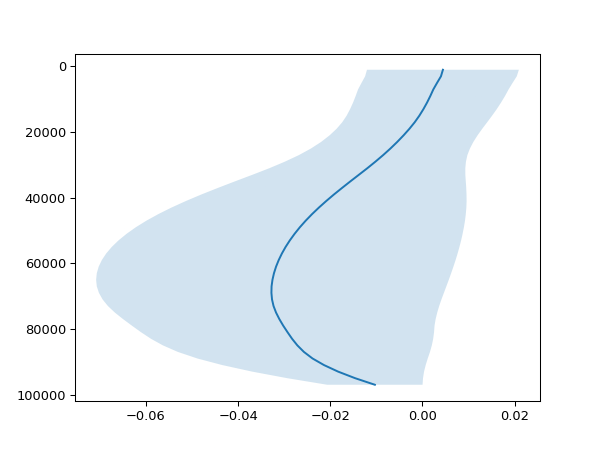

In [4]:
with gzip.open('/home/scratch/Abel_data/vertk', 'rb') as f:
    vert=pickle.load(f)
    
vert=np.array(vert)
mean=np.mean(vert, axis=0)
std=np.std(vert, axis=0)

plt.plot(mean, p_std)
plt.fill_betweenx(p_std, mean-std,mean+std, alpha =0.2)
plt.gca().invert_yaxis()